In [37]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import plotly.graph_objects as go
from math import sqrt, pi
import plotly.express as px
from tqdm import tqdm
import sys
import os
from sklearn.decomposition import PCA
import torch

sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values, state_to_return, pauli_to_int, int_to_pauli, basis_T_to_pauli,\
    reversed_str_bases_to_init_state, kernel_qaoa_Preserved, kernel_flipped, get_optimizer, optimizer_names, all_state_to_return, get_init_states

import time

cudaq.set_target("nvidia")

np.random.seed(42)

!! warning: Representing Pauli words using INTEGER !!

In [38]:
print(4**30 // 10**18)

1


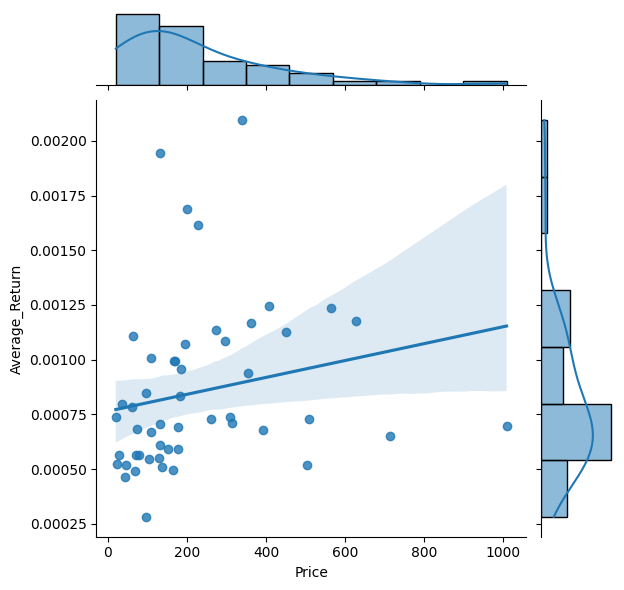

20.049999237060547 1008.5
0.0002817427940077 0.0020945858866767


In [39]:
import seaborn as sns
from copulas.multivariate import GaussianMultivariate
import joblib
data_cov = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_covariance.csv")
data_ret_p = pd.read_csv("../dataset/top_50_us_stocks_returns_price.csv")

data = data_ret_p.drop("Ticker", axis=1)
sns.jointplot(data=data, x='Price', y='Average_Return', kind='reg')
plt.show()

print(data["Price"].min(), data["Price"].max())
print(data["Average_Return"].min(), data["Average_Return"].max())

In [40]:
# X = data[['Price', 'Average_Return']]
# GM = GaussianMultivariate()
# GM.fit(X)
# joblib.dump(GM, './models/gaussian_copula.pkl')

In [41]:
covv = np.array(data_cov.iloc[:, 1:])
# print(covv[:4, :4])
print(covv.min(), covv.max())

# covv = np.roll(covv, np.arange(covv.shape[0]), axis=1)
for i in range(covv.shape[0]):
    covv[i] = np.roll(covv[i], -i)
# print(covv[:4, :4])

GM2 = GaussianMultivariate()
print(data_cov)
print(covv[:4, :4])
# GM2.fit(covv)
# joblib.dump(GM2, './models/gaussian_copula_covariance.pkl')

3.2280401565736774e-05 0.0014335365624835
   Ticker      AAPL      ABBV       ABT       ACN      ADBE       AMD  \
0    AAPL  0.000772  0.000078  0.000100  0.000151  0.000305  0.000354   
1    ABBV  0.000078  0.000279  0.000103  0.000085  0.000095  0.000096   
2     ABT  0.000100  0.000103  0.000256  0.000095  0.000115  0.000127   
3     ACN  0.000151  0.000085  0.000095  0.000350  0.000189  0.000234   
4    ADBE  0.000305  0.000095  0.000115  0.000189  0.000924  0.000366   
5     AMD  0.000354  0.000096  0.000127  0.000234  0.000366  0.001387   
6    AMZN  0.000303  0.000075  0.000090  0.000181  0.000349  0.000412   
7    AVGO  0.000209  0.000096  0.000099  0.000164  0.000217  0.000353   
8     BMY  0.000103  0.000107  0.000121  0.000089  0.000116  0.000122   
9   BRK-B  0.000088  0.000079  0.000066  0.000100  0.000103  0.000131   
10  CMCSA  0.000150  0.000081  0.000098  0.000142  0.000200  0.000206   
11   COST  0.000151  0.000055  0.000091  0.000109  0.000171  0.000170   
12    CRM

In [42]:
GM2_load = joblib.load('./models/gaussian_copula_covariance.pkl')
samples_cov = GM2_load.sample(50)
# print(samples_cov)
samples_cov = np.array(samples_cov)
samples_cov = np.abs(samples_cov)
for i in range(samples_cov.shape[0]):
    samples_cov[i] = np.roll(samples_cov[i], i)
samples_cov = (samples_cov + samples_cov.T) / 2
print(covv.min(), covv.max())
print(samples_cov.min(), samples_cov.max())
print(samples_cov[:4, :4])

3.2280401565736774e-05 0.0014335365624835
2.6547838908660948e-05 0.0016337088882497008
[[2.26715146e-04 9.71586926e-05 1.08840517e-04 9.60888384e-05]
 [9.71586926e-05 2.51348894e-04 9.22736697e-05 7.74768395e-05]
 [1.08840517e-04 9.22736697e-05 6.58766660e-04 8.14066594e-05]
 [9.60888384e-05 7.74768395e-05 8.14066594e-05 4.25827149e-04]]


0.00046289733685079767 0.0019394137233065217


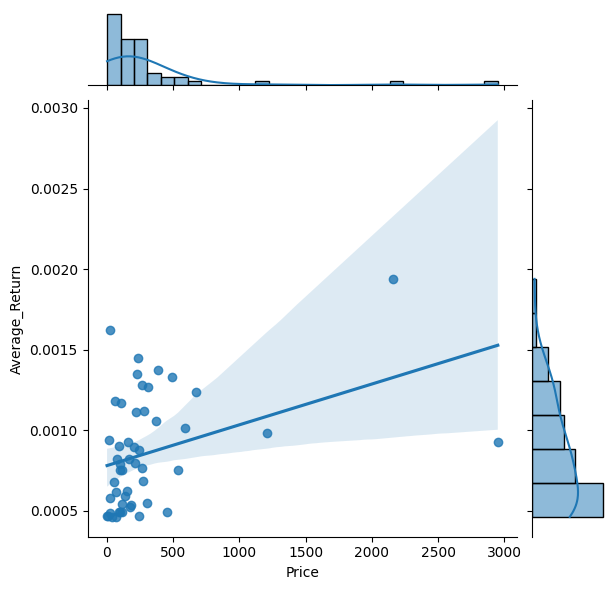

In [43]:
GM_loaded = joblib.load('./models/gaussian_copula.pkl')
samples = GM_loaded.sample(50)
print(samples["Average_Return"].min(), samples["Average_Return"].max())
sns.jointplot(data=samples, x='Price', y='Average_Return', kind='reg')
plt.show()

# HAMILTONIAN BY CUDAQ

### by random values

In [44]:
B = 100
ret = np.array([1.0, 1.25, 1.5])
cov = np.random.rand(3, 3)
cov += cov.T
print(cov)
P = np.array([100, 100, 100])
lamb = 0 # Budget Penalty
q = 0 # Volatility Weight

# P_b, ret_b, cov_b = po_normalize(B, P, ret, cov)
P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, P, ret, cov)

print("n_qubit:", n_qubit)
print("n_max:", n_max)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)

[[0.86694447 1.31834451 0.93159256]
 [1.31834451 0.44022265 0.41923421]
 [0.93159256 0.41923421 0.7391484 ]]
n_qubit: 3
n_max: [1 1 1]


In [45]:
print("Hamiltonian:", H)
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: (-0.5+0i) * I0 + (0.5+0i) * Z0 + (0+0i) + (-0.625+0i) * I1 + (0.625+0i) * Z1 + (-0.75+0i) * I2 + (0.75+0i) * Z2
[0, 1, 2]
[0.5, 0.625, 0.75]

[]
[]
[]


### by stock values

In [46]:
data_cov = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_covariance.csv")
data_ret_p = pd.read_csv("../dataset/top_50_us_stocks_returns_price.csv")

nn = 3 # num assets
# B = 1500
B = 270
lamb = 1 # Budget Penalty
q = 1 # Volatility Weight

data_cov = data_cov.drop("Ticker", axis=1).iloc[:nn, :nn]
print(data_cov)
data_ret_p = data_ret_p.iloc[:nn]
# data_ret_p.loc[0, "Average_Return"] = 0.002070
# data_ret_p.loc[1, "Average_Return"] = 0.000050
# data_ret_p.loc[2, "Average_Return"] = 0.002070
print(data_ret_p)
stock_names = data_ret_p["Ticker"].tolist()
data_ret_p = data_ret_p.drop("Ticker", axis=1)

data_cov = data_cov.to_numpy()
data_ret_p = data_ret_p.to_numpy()

data_ret = data_ret_p[:, 0]
data_p = data_ret_p[:, 1]

data_p = np.array([174.34238699, 129.46979175, 163.35661173])
data_ret = np.array([0.00147772, 0.00055953, 0.00173287])
B = 281.25

print(data_cov.shape)
print(data_ret.round(5))
print(data_p.round(2))
print(stock_names)

       AAPL      ABBV       ABT
0  0.000772  0.000078  0.000100
1  0.000078  0.000279  0.000103
2  0.000100  0.000103  0.000256
  Ticker  Average_Return       Price
0   AAPL        0.001070  195.270004
1   ABBV        0.000832  183.259995
2    ABT        0.000706  131.300003
(3, 3)
[0.00148 0.00056 0.00173]
[174.34 129.47 163.36]
['AAPL', 'ABBV', 'ABT']


In [47]:
a = 5
a += spin.z(0)
print(a.canonicalize())

(5+0i) + (1+0i) * Z0


In [48]:
P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, data_p, data_ret, data_cov)

print(cov_bb)
print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb).canonicalize() * 500

[[2.96715551e-04 2.22759456e-05 4.45518911e-05 3.59261251e-05]
 [2.22759456e-05 5.90372372e-05 1.18074474e-04 2.75926962e-05]
 [4.45518911e-05 1.18074474e-04 2.36148949e-04 5.51853924e-05]
 [3.59261251e-05 2.75926962e-05 5.51853924e-05 8.64641496e-05]]
n_qubit: 4


In [49]:
print(QU)
print("Hamiltonian:", H/500)
# print("H canonicalized:", H.canonicalize())
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

[[-0.85613116  0.28537786  0.57075572  0.36007915]
 [ 0.28537786 -0.70896242  0.42393845  0.26740217]
 [ 0.57075572  0.42393845 -0.99398639  0.53480433]
 [ 0.36007915  0.26740217  0.53480433 -0.8252111 ]]
Hamiltonian: (0.529033+0i) + (-0.180041+0i) * Z0 + (-0.133878+0i) * Z1 + (0.142689+0i) * Z0Z1 + (-0.267756+0i) * Z2 + (0.285378+0i) * Z0Z2 + (-0.168537+0i) * Z3 + (0.18004+0i) * Z0Z3 + (0.211969+0i) * Z1Z2 + (0.133701+0i) * Z1Z3 + (0.267402+0i) * Z2Z3
[0, 1, 2, 3]
[-90.02039274061626, -66.93901346496341, -133.8780269299268, -84.26863786570382]

[0, 0, 0, 1, 1, 2]
[1, 2, 3, 2, 3, 3]
[71.3444649051455, 142.688929810291, 90.01978763768835, 105.98461258901791, 66.8505414385825, 133.701082877165]


In [50]:
@cudaq.kernel
def kernel_simple(qb:int, idxs: List[int])-> None:
    qvec = cudaq.qvector(qb)
    for idx in idxs:
        x(qvec[idx])

In [51]:
# print(cudaq.sample(kernel_simple, n_qubit, 2, shots_count=int(1e4)))
exp = cudaq.observe(kernel_simple, H/500, n_qubit, [0, 1]).expectation()
print(exp)

0.005662138919999504


In [79]:
v = np.array(list(map(int, "1111")))
# print(v.T.shape)
lambb = 0
qq = 1
QU2 = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lambb, qq)
print(QU2)
print(v @ QU2 @ v + lambb)

[[-6.19299497e-04  2.22759456e-05  4.45518911e-05  3.59261251e-05]
 [ 2.22759456e-05 -1.98535145e-04  1.18074474e-04  2.75926962e-05]
 [ 4.45518911e-05  1.18074474e-04 -2.78995816e-04  5.51853924e-05]
 [ 3.59261251e-05  2.75926962e-05  5.51853924e-05 -9.20027483e-04]]
-0.001409644891726067


In [53]:
print((P_bb.sum()-1)**2)

2.501833928896568


In [74]:
s = 1
for i in range(len(v)):
    # s -= P_bb[i]**2 * v[i]
    s -= 2 * P_bb[i] * v[i]
for i in range(len(v)):
    for j in range(len(v)):
        s += 1 * P_bb[i] * P_bb[j] * v[i] * v[j]
print(s * lambb)

0.0


In [75]:
print(0.0005**2)

2.5e-07


In [73]:
print(P_bb)
print(ret_bb)
print(cov_bb, end="\n\n")
print(-1 * v@ret_bb + qq * v@cov_bb@v + lambb * (v@P_bb - 1)**2)

[0.61988404 0.46033704 0.92067407 0.58082351]
[0.00091602 0.00025757 0.00051514 0.00100649]
[[2.96715551e-04 2.22759456e-05 4.45518911e-05 3.59261251e-05]
 [2.22759456e-05 5.90372372e-05 1.18074474e-04 2.75926962e-05]
 [4.45518911e-05 1.18074474e-04 2.36148949e-04 5.51853924e-05]
 [3.59261251e-05 2.75926962e-05 5.51853924e-05 8.64641496e-05]]

-0.001409644891726067


# Time Benchmark

In [15]:
print(list(map(int, "0010")))

[0, 0, 1, 0]


In [ ]:
# qb = 22
# st = time.time()
# l = np.zeros((1<<qb, qb))
# for i in range(1<<qb):
#     s = bin(i)[2:].zfill(qb)
#     ll = np.array(list(map(int, s)))
#     l[i] = ll
# print(time.time() - st) # 7.1 sec

7.237088203430176


In [63]:
qb = 25
st = time.time()
l = np.zeros((qb, 1<<qb), dtype=np.float32)
a_0 = np.zeros(1<<qb, dtype=np.float32)
a_1 = np.ones(1<<qb, dtype=np.float32)
idxx = np.arange(1<<qb, dtype=np.int32)
# print(a_0, a_1)
for i in range(qb):
    l[i] = np.where(idxx%(1<<(qb-i))<(1<<(qb-i-1)), a_0,  a_1)
# print(l)
print(time.time() - st) # 4.8 sec

2.643104314804077


In [ ]:
qb = 25
st = time.time()
lt = torch.zeros((qb, 1<<qb), dtype=torch.float32, device='cuda')
print(lt.device)
a_0 = torch.zeros(1<<qb, dtype=torch.float32, device='cuda')
a_1 = torch.ones(1<<qb, dtype=torch.float32, device='cuda')
idxx = torch.arange(1<<qb, device='cuda')
for i in range(qb):
    lt[i] = torch.where(idxx%(1<<(qb-i))<(1<<(qb-i-1)), a_0,  a_1)
lt = lt.numpy(force=True)
print(time.time() - st) # int8: 1.0, float32: 1.6
print(lt)

cuda:0
1.0170478820800781


In [ ]:
a = np.array()

In [12]:
# def state_to_return(s, B, C, d_ret, d_p):
#     l = np.array(list(map(int, s)))
#     P = d_p @ C
#     ret_C = (d_ret * d_p) @ C
#     ss = l @ ret_C
#     bud = l @ P
#     return ss, bud <= B

# ex_ret, in_budget = state_to_return("0001", B, C, data_ret, data_p)
# print(ex_ret, in_budget)

# CUDA QAOA

In [13]:
idx_1_use, coeff_1_use = idx_1, coeff_1
idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a, idx_2_b, coeff_2

# idx_1_use, coeff_1_use = idx_1_qis, coeff_1_qis
# idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a_qis, idx_2_b_qis, coeff_2_qis

In [14]:
print(H)
print(n_qubit)

(-0.673806+0i) + (0.229004+0i) * Z0 + (0.0643931+0i) * Z1 + (0.128786+0i) * Z2 + (0.251623+0i) * Z3
4


In [15]:
# bases = ["0001", "0010"]
# T = np.array([[0, 1], [1, 0]])
# mixer_s, mixer_c, A_all = basis_T_to_pauli(bases, T, len(bases[0]))
# print(f"{mixer_s}\n{mixer_c}")

# print(A_all.to_matrix())

# # AA_all = A_all.copy()
# AA_all = 0.25 * spin.x(0) * spin.x(2) + 0.25 * spin.x(0) * spin.z(1) * spin.x(2) \
#        + 0.25 * spin.y(0) * spin.y(2) + 0.25 * spin.y(0) * spin.z(1) * spin.y(2)
# print(AA_all.to_matrix())

In [ ]:
# init_bases = ["100", "010", "001"]
# T = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])

# init_bases = ["1000", "0100", "0001"]
init_bases = ['0001', '1000', '0010']
# init_bases = ["100000", "010000", "000100"]
T = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])

mixer_s, mixer_c = basis_T_to_pauli(init_bases, T, n_qubit)

print(f"{mixer_s}\n{mixer_c}")
init_bases = reversed_str_bases_to_init_state(init_bases, n_qubit)
print("init_bases:", abs(init_bases))

# state_return, in_budget = all_state_to_return(B, C, data_ret, data_p, 1.0)
# init_state = get_init_states(state_return, in_budget, 0.02, n_qubit)
# # init_state = get_init_states(state_return, in_budget, 0.2, n_qubit)
# n_bases = len(init_state)
# print("n_bases:", n_bases)
# # print(init_state)
# T = np.zeros((n_bases, n_bases), dtype=np.float32)
# T[:-1, 1:] += np.eye(n_bases - 1, dtype=np.float32)
# T[1:, :-1] += np.eye(n_bases - 1, dtype=np.float32)
# T[0, -1] = T[-1, 0] = 1.0
# print(T)
# mixer_s, mixer_c = basis_T_to_pauli(init_state, T, n_qubit)
# # mixer_c *= 100
# init_bases = reversed_str_bases_to_init_state(init_state, n_qubit)
# # print(f"{mixer_s}\n{mixer_c}")
# print(mixer_c[0])
# print("init_bases:", abs(init_bases))

['XIIX', 'XIZX', 'XZIX', 'XZZX', 'YIIY', 'YIZY', 'YZIY', 'YZZY', 'IIXX', 'IZXX', 'ZIXX', 'ZZXX', 'IIYY', 'IZYY', 'ZIYY', 'ZZYY', 'XIXI', 'XIXZ', 'XZXI', 'XZXZ', 'YIYI', 'YIYZ', 'YZYI', 'YZYZ']
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125
 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
init_bases: [0.         0.57735026 0.         0.         0.57735026 0.
 0.         0.         0.57735026 0.         0.         0.
 0.         0.         0.         0.        ]


In [17]:
print(mixer_s[:2])
print(mixer_c[:2])
print(coeff_1_use)

['XIIX', 'XIZX']
[0.125 0.125]
[0.2290037618692114, 0.06439309562478, 0.12878619124956, 0.2516229082387245]


In [18]:
a = "AB"
for i, c in enumerate(a):
    print(i, c)
print()
for i, c in reversed(list(enumerate(a[:-1]))):
    print(i, c)

0 A
1 B

0 A


In [19]:
def nplize(a):
    for i in range(len(a)):
        a[i] = np.array(a[i])
    return a

In [20]:
a = [[1, 2, np.array(3)], [1, 2, np.array(3)]]
print(nplize(a))
a = [1, 2, np.array(3)]
b = [*a]
print(b)

[array([1, 2, 3]), array([1, 2, 3])]
[1, 2, array(3)]


In [21]:
def prepare_preserving_ansatz(qubit_count: int, idx_1: List[int], coeff_1: List[float], idx_2_a: List[int], idx_2_b: List[int], coeff_2: List[float], mixer_str: List[cudaq.pauli_word], mixer_coeff: List[float]):
    def generate_list():
        return [[] for _ in range(qubit_count)]
    type_l, zeta_l, entang_l, runnum_l = [generate_list() for _ in range(4)]
    cou = 0
    all_gate, mk = [], []
    def remove(idx):
        tp = type_l[idx].pop()
        zt = zeta_l[idx].pop()
        et = entang_l[idx].pop()
        rn = runnum_l[idx].pop()
        mk[rn] = False
        # print("-", idx, rn, tp, zt, et)
    def add(typee, idx, zeta, idx_en):
        nonlocal cou
        # print("+", idx, cou, typee, zeta, idx_en)
        type_l[idx].append(typee)
        zeta_l[idx].append(zeta)
        entang_l[idx].append(idx_en)
        runnum_l[idx].append(cou)
        mk.append(typee != 5)
        all_gate.append([typee, idx, *zeta, idx_en])
        cou += 1
    def nplize(a):
        for i in range(len(a)):
            a[i] = np.array(a[i], dtype=np.float32)
        return a
    def is_zero(val, bound=1e-8):
        return abs(val) < bound
    def push(typee, idx, zeta=[0, 0, 0], idx_en=-1): # typee[0: RX, 1: RY, 2: RZ, 3: H, 4: CX-control, 5: CX-target], zeta: (const_coeff, problem_coeff, mixer_coeff)
        nonlocal cou
        # print("*", idx, cou, typee, zeta, idx_en)
        if len(type_l[idx]) > 0 and type_l[idx][-1] == typee:
            if typee <= 3:
                if not (is_zero(zeta_l[idx][-1][0] + zeta[0]) and is_zero(zeta_l[idx][-1][1] + zeta[1]) and is_zero(zeta_l[idx][-1][2] + zeta[2])):
                    for i in range(3):
                        zeta_l[idx][-1][i] += zeta[i]
                        all_gate[runnum_l[idx][-1]][i + 2] = zeta_l[idx][-1][i]
                    print("^", idx, runnum_l[idx][-1], typee, zeta_l[idx][-1])
                else:
                    remove(idx)
            if typee == 4:
                if len(entang_l[entang_l[idx][-1]]) > 0 and idx_en == entang_l[idx][-1] and idx == entang_l[entang_l[idx][-1]][-1]:
                    remove(idx)
                    remove(entang_l[idx][-1])
                else:
                    add(typee, idx, zeta, idx_en)
                    add(5, idx_en, [0, 0, 0], idx)
        else:
            add(typee, idx, zeta, idx_en)
            if typee == 4:
                add(5, idx_en, [0, 0, 0], idx)

            # print(idx)
    def push_pauli_string(strr, coeff):
        for i, p in enumerate(strr):
            if p == "X":
                push(3, i)
            elif p == "Y":
                push(0, i, [pi/2, 0, 0])
                # push(3, i)
        ll = -1
        for i, p in enumerate(strr):
            if p in ["X", "Y", "Z"]:
                if ll != -1:
                    push(4, ll, idx_en=i)
                    # push(5, i, idx_en=ll)
                ll = i
        push(2, ll, [0, 0, -2 * coeff])
        ll = -1
        for i, p in reversed(list(enumerate(strr))):
            if p in ["X", "Y", "Z"]:
                if ll != -1:
                    push(4, i, idx_en=ll)
                    # push(5, ll, idx_en=i)
                ll = i
        for i, p in enumerate(strr):
            if p == "X":
                push(3, i)
            elif p == "Y":
                # push(3, i)
                push(0, i, [-pi/2, 0, 0])
    
    for j in range(len(idx_1)):
        push(2, idx_1[j], [0, 2 * coeff_1[j], 0])
    for j in range(len(idx_2_a)):
        push(4, idx_2_a[j], idx_en=idx_2_b[j])
        # push(5, idx_2_b[j], idx_en=idx_2_a[j])
        push(2, idx_2_b[j], [0, 2 * coeff_2[j], 0])
        push(4, idx_2_a[j], idx_en=idx_2_b[j])
        # push(5, idx_2_b[j], idx_en=idx_2_a[j])
    for j in range(len(mixer_str)):
        push_pauli_string(mixer_str[j], mixer_coeff[j])

    # print(all_gate[6])
    return [nplize(i) for i in[type_l, zeta_l, entang_l, runnum_l]] + nplize([all_gate, mk])

type_l, zeta_l, entang_l, runnum_l, all_gate, mk = prepare_preserving_ansatz(n_qubit, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c.tolist())
# type_l, zeta_l, entang_l, runnum_l, all_gate, mk = prepare_preserving_ansatz(n_qubit, idx_1_use, coeff_1_use, [0], [1], [0.3], ["ZZII", "XXZI"], mixer_c[:2].tolist())
all_gate = all_gate[mk == 1].reshape(-1)

In [22]:
print(mk)

[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.]


In [23]:
# print(len(all_gate), all_gate)
ag = all_gate.reshape(-1, 6)
al = [[] for _ in range(4)]
for i in range(len(ag)):
    al[int(ag[i][1])].append(ag[i])
# print(al)
for ii in range(len(al)):
    print(ii)
    for i in range(len(al[ii])):
        print(al[ii][i].tolist())
    print()

0
[2.0, 0.0, 0.0, 0.4580075144767761, 0.0, -1.0]
[3.0, 0.0, 0.0, 0.0, 0.0, -1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 3.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 3.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[3.0, 0.0, 0.0, 0.0, 0.0, -1.0]
[0.0, 0.0, 1.5707963705062866, 0.0, 0.0, -1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 3.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 3.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[0.0, 0.0, -1.5707963705062866, 0.0, 0.0, -1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[3.0, 0.0, 0.0, 0.0, 0.0, -1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[3.0, 0.0, 0.0, 

In [24]:
for ii in range(len(type_l)):
    print(ii)
    for i in range(len(type_l[ii])):
        print(type_l[ii][i], zeta_l[ii][i].tolist(), entang_l[ii][i], runnum_l[ii][i])
    print()


0
2.0 [0.0, 0.4580075144767761, 0.0] -1.0 0.0
3.0 [0.0, 0.0, 0.0] -1.0 4.0
4.0 [0.0, 0.0, 0.0] 3.0 6.0
4.0 [0.0, 0.0, 0.0] 3.0 9.0
4.0 [0.0, 0.0, 0.0] 2.0 13.0
4.0 [0.0, 0.0, 0.0] 2.0 20.0
4.0 [0.0, 0.0, 0.0] 1.0 24.0
4.0 [0.0, 0.0, 0.0] 1.0 44.0
3.0 [0.0, 0.0, 0.0] -1.0 46.0
0.0 [1.5707963705062866, 0.0, 0.0] -1.0 48.0
4.0 [0.0, 0.0, 0.0] 3.0 50.0
4.0 [0.0, 0.0, 0.0] 3.0 53.0
4.0 [0.0, 0.0, 0.0] 2.0 57.0
4.0 [0.0, 0.0, 0.0] 2.0 64.0
4.0 [0.0, 0.0, 0.0] 1.0 68.0
4.0 [0.0, 0.0, 0.0] 1.0 88.0
0.0 [-1.5707963705062866, 0.0, 0.0] -1.0 90.0
4.0 [0.0, 0.0, 0.0] 2.0 112.0
4.0 [0.0, 0.0, 0.0] 2.0 119.0
4.0 [0.0, 0.0, 0.0] 1.0 123.0
4.0 [0.0, 0.0, 0.0] 1.0 134.0
4.0 [0.0, 0.0, 0.0] 2.0 158.0
4.0 [0.0, 0.0, 0.0] 2.0 165.0
4.0 [0.0, 0.0, 0.0] 1.0 169.0
4.0 [0.0, 0.0, 0.0] 1.0 180.0
3.0 [0.0, 0.0, 0.0] -1.0 184.0
4.0 [0.0, 0.0, 0.0] 2.0 186.0
4.0 [0.0, 0.0, 0.0] 2.0 198.0
4.0 [0.0, 0.0, 0.0] 1.0 202.0
4.0 [0.0, 0.0, 0.0] 1.0 220.0
3.0 [0.0, 0.0, 0.0] -1.0 222.0
0.0 [1.5707963705062866, 0.0, 0.0] -

In [25]:
@cudaq.kernel
def kernel_cmpz_Preserved(thetas: List[float], qubit_count: int, layer_count: int, params: List[float], init_sup: List[complex]):
    qreg = cudaq.qvector(init_sup)

    for i in range(layer_count):
        for j in range(len(params) // 6):
            typee = params[6 * j]
            idx = int(params[6 * j + 1])
            zeta = params[6*j+2] + thetas[i] * params[6*j+3] + thetas[i+layer_count] * params[6*j+4]

            if typee  == 0: # RX
                rx(zeta, qreg[idx])
            elif typee == 1: # RY
                ry(zeta, qreg[idx])
            elif typee == 2: # RZ
                rz(zeta, qreg[idx])
            elif typee == 3: # H
                h(qreg[idx])
            elif typee == 4: # CX-control
                cx(qreg[idx], qreg[int(params[6*j+5])])


In [26]:
print(cudaq.draw(kernel_qaoa_Preserved, [1.0]*4, n_qubit, 1, idx_1_use, coeff_1_use, [0], [1], [0.3], ["ZZII", "XXZI"], mixer_c[:2], init_bases))

     ╭───────────╮                                             ╭───╮          »
q0 : ┤ rz(0.458) ├───●───────────────●────●─────────────────●──┤ h ├──●───────»
     ├───────────┴╮╭─┴─╮╭─────────╮╭─┴─╮╭─┴─╮╭───────────╮╭─┴─╮├───┤╭─┴─╮     »
q1 : ┤ rz(0.1288) ├┤ x ├┤ rz(0.6) ├┤ x ├┤ x ├┤ rz(-0.25) ├┤ x ├┤ h ├┤ x ├──●──»
     ├────────────┤╰───╯╰─────────╯╰───╯╰───╯╰───────────╯╰───╯╰───╯╰───╯╭─┴─╮»
q2 : ┤ rz(0.2576) ├──────────────────────────────────────────────────────┤ x ├»
     ├────────────┤                                                      ╰───╯»
q3 : ┤ rz(0.5032) ├───────────────────────────────────────────────────────────»
     ╰────────────╯                                                           »

################################################################################

                       ╭───╮
────────────────────●──┤ h ├
                  ╭─┴─╮├───┤
───────────────●──┤ x ├┤ h ├
╭───────────╮╭─┴─╮╰───╯╰───╯
┤ rz(-0.25) ├┤ x ├──────────
╰───────────╯╰───╯     

In [27]:
for i in ag:
    print(i.tolist())

[2.0, 0.0, 0.0, 0.4580075144767761, 0.0, -1.0]
[2.0, 1.0, 0.0, 0.12878619134426117, 0.0, -1.0]
[2.0, 2.0, 0.0, 0.25757238268852234, 0.0, -1.0]
[2.0, 3.0, 0.0, 0.5032458305358887, 0.0, -1.0]
[3.0, 0.0, 0.0, 0.0, 0.0, -1.0]
[3.0, 3.0, 0.0, 0.0, 0.0, -1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 3.0]
[2.0, 3.0, 0.0, 0.0, -0.25, -1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 3.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 2.0, 0.0, 0.0, 0.0, 3.0]
[2.0, 3.0, 0.0, 0.0, -0.25, -1.0]
[4.0, 2.0, 0.0, 0.0, 0.0, 3.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 1.0, 0.0, 0.0, 0.0, 3.0]
[2.0, 3.0, 0.0, 0.0, -0.25, -1.0]
[4.0, 1.0, 0.0, 0.0, 0.0, 3.0]
[4.0, 1.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 2.0, 0.0, 0.0, 0.0, 3.0]
[2.0, 3.0, 0.0, 0.0, -0.25, -1.0]
[4.0, 2.0, 0.0, 0.0, 0.0, 3.0]
[4.0, 1.0, 0.0, 0.0, 0.0, 2.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[3.0, 0.0, 0.0, 0.0, 0.0, -1.0]
[3.0, 3.0, 0.0, 0.0, 0.0, -1.0]
[0.0, 0.0, 1.5707963705062866, 0.0, 0.0, -1.0]
[0.0, 3.0, 1.5707963705062866, 0.0, 0.0, -1.0]
[4.0, 0.0, 0.0, 0.

In [28]:
print(cudaq.draw(kernel_cmpz_Preserved, [1.0]*4, n_qubit, 1, all_gate, init_bases))

     ╭───────────╮ ╭───╮                                                   »
q0 : ┤ rz(0.458) ├─┤ h ├──●─────────────────●────●─────────────────────────»
     ├───────────┴╮╰───╯  │                 │    │                         »
q1 : ┤ rz(0.1288) ├───────┼─────────────────┼────┼─────────────────────────»
     ├────────────┤       │                 │  ╭─┴─╮                       »
q2 : ┤ rz(0.2576) ├───────┼─────────────────┼──┤ x ├──●─────────────────●──»
     ├────────────┤╭───╮╭─┴─╮╭───────────╮╭─┴─╮╰───╯╭─┴─╮╭───────────╮╭─┴─╮»
q3 : ┤ rz(0.5032) ├┤ h ├┤ x ├┤ rz(-0.25) ├┤ x ├─────┤ x ├┤ rz(-0.25) ├┤ x ├»
     ╰────────────╯╰───╯╰───╯╰───────────╯╰───╯     ╰───╯╰───────────╯╰───╯»

################################################################################

                                                                  »
──●────●──────────────────────────────────────────────────────────»
  │  ╭─┴─╮                                                        »
──┼──┤ x ├──●───────

In [29]:
print(mixer_s)

['XIIX', 'XIZX', 'XZIX', 'XZZX', 'YIIY', 'YIZY', 'YZIY', 'YZZY', 'IIXX', 'IZXX', 'ZIXX', 'ZZXX', 'IIYY', 'IZYY', 'ZIYY', 'ZZYY', 'XIXI', 'XIXZ', 'XZXI', 'XZXZ', 'YIYI', 'YIYZ', 'YZYI', 'YZYZ']


In [30]:
print(cudaq.draw(kernel_qaoa_Preserved, [1]*4, n_qubit, 1, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, init_bases))

     ╭───────────╮ ╭───╮                       ╭───╮╭───╮          »
q0 : ┤ rz(0.458) ├─┤ h ├──●─────────────────●──┤ h ├┤ h ├──●───────»
     ├───────────┴╮╰───╯  │                 │  ╰───╯╰───╯  │       »
q1 : ┤ rz(0.1288) ├───────┼─────────────────┼──────────────┼───────»
     ├────────────┤       │                 │            ╭─┴─╮     »
q2 : ┤ rz(0.2576) ├───────┼─────────────────┼────────────┤ x ├──●──»
     ├────────────┤╭───╮╭─┴─╮╭───────────╮╭─┴─╮╭───╮╭───╮╰───╯╭─┴─╮»
q3 : ┤ rz(0.5032) ├┤ h ├┤ x ├┤ rz(-0.25) ├┤ x ├┤ h ├┤ h ├─────┤ x ├»
     ╰────────────╯╰───╯╰───╯╰───────────╯╰───╯╰───╯╰───╯     ╰───╯»

################################################################################

                       ╭───╮╭───╮                                 ╭───╮╭───╮»
────────────────────●──┤ h ├┤ h ├──●───────────────────────────●──┤ h ├┤ h ├»
                    │  ╰───╯╰───╯╭─┴─╮                       ╭─┴─╮╰───╯╰───╯»
────────────────────┼────────────┤ x ├──●─────────────────●──┤

# Ansatz Architecture

In [31]:
idx = 3
layer_count = 5
ansatz_idx = 0

parameter_count = layer_count * 2
optimizer, optimizer_name, FIND_GRAD = get_optimizer(idx)

optimizer.max_iterations = 1000


optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

kernel_qaoa_use = None
ansatz_fixed_param = None
if ansatz_idx == 0:
    ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, init_bases)
    kernel_qaoa_use = kernel_qaoa_Preserved
elif ansatz_idx == 1:
    preserving_gates, mk = prepare_preserving_ansatz(n_qubit, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c.tolist())[-2:]
    preserving_gates = preserving_gates[mk == 1].reshape(-1)
    ansatz_fixed_param = (int(n_qubit), layer_count, preserving_gates, init_bases)
    kernel_qaoa_use = kernel_cmpz_Preserved

Initial parameters =  [0.3705367812928655, 0.36320525611565224, -0.19494972898149013, -0.0021610184187193515, -0.1563898097625048, -0.16898588055343988, -0.3637281409931357, 0.0860516266816756, 0.002104099923646907, -0.3522677650129884]


In [32]:
print(optimizer.episodes)

None


In [98]:
def plot_px_surface(points, nx=80, ny=80, method="linear", title="3D Surface", opacity=0.95):
    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    ux = np.linspace(-5, 5, nx)
    uy = np.linspace(-5, 5, ny)
    Xg, Yg = np.meshgrid(ux, uy)
    Zg = griddata(points=np.c_[x, y], values=z, xi=(Xg, Yg), method=method)
    # Zg[np.isnan(Zg)] = griddata(np.c_[x, y], z, (Xg[np.isnan(Zg)], Yg[np.isnan(Zg)]), method="nearest")

    fig = go.Figure(data=[go.Surface(x=Xg, y=Yg, z=Zg, colorscale="Viridis", opacity=opacity)])
    fig.update_layout(
        title=title,
        # width=1000,
        height=800,
        margin=dict(l=0, r=0, b=0, t=30),
        scene=dict(
            xaxis_title="PCA-1 (init param)",
            yaxis_title="PCA-2 (init param)",
            zaxis_title="Loss / Eval",
            camera=dict(eye=dict(x=0.5, y=0.5, z=0.5)),
        ),
    )
    fig.show()

In [57]:
n_points = 3000
points = np.random.uniform(-np.pi, np.pi, (n_points, parameter_count))
pca = PCA(n_components=2)
points_2d = pca.fit_transform(points)
expec = []
pbar = tqdm(range(len(points)))
for i in pbar:
    expec.append(float(cudaq.observe(kernel_qaoa_use, H, points[i], *ansatz_fixed_param).expectation()))
points_3d = np.concatenate([points_2d, np.array(expec).reshape(-1, 1)], axis=1)
print(points_3d.shape)

100%|██████████| 3000/3000 [00:40<00:00, 74.00it/s]

(3000, 3)


In [ ]:
exp_np = np.array(expec)
print(exp_)

In [101]:
plot_px_surface(points_3d, title="Expectation Landscape", opacity=1, method="cubic")

# Optimize

In [ ]:
expectations = []

def cost_func(parameters):
    # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
    return cudaq.observe(kernel_qaoa_use, H, parameters, *ansatz_fixed_param).expectation()

def objective(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)
    return expectation

def objective_grad_cuda(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)

    gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

    return expectation, gradient

objective_func = objective_grad_cuda if FIND_GRAD else objective
print("Required Gradient = ", FIND_GRAD)

Required Gradient =  True


In [ ]:
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()

if not os.path.exists("./output_PO_mixer"):
    os.makedirs("./output_PO_mixer")
np.save(f"./output_PO_mixer/expectations_{optimizer_name}.npy", np.array(expectations))

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

optimal_expectation = -0.49645346374145716
optimal_parameters = [-0.026224271586925828, -0.01657881871711394, -0.39485076940040426, -0.3593490223423831, -0.5367617261721944, -0.032287990551702554, -0.7247202352003079, 0.5166255970411221, 0.40275339935937726, -0.5321057582151864]
Time taken =  0.7543861865997314


In [ ]:
shots_count = int(1e6)
print(f"Sampling {shots_count} times...")
# result = cudaq.sample(kernel_qaoa, int(n_qubit), layer_count, optimal_parameters, 0, shots_count=shots_count)
result = cudaq.sample(kernel_qaoa_use, optimal_parameters, *ansatz_fixed_param, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**n_qubit - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(n_qubit)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
# print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)
print("|q0>|q1>|q2>...")



Sampling 1000000 times...
Finding the best solution...
0001 862190 0.86219
|q0>|q1>|q2>...


In [ ]:
state = cudaq.get_state(kernel_qaoa_use, optimal_parameters, *ansatz_fixed_param)
# print(state)

rows = []
col = ["State", "Probability", "Return", "In_Budget"]
ret_sum = 0
state_best, return_best = "", 0
state_high, return_high = result.most_probable(), 0
for i in range(len(state)):
    bb = bin(i)[2:].zfill(n_qubit)
    ret, in_bud = state_to_return(bb, B, C, data_ret, data_p)
    if in_bud and ret > return_best:
        state_best, return_best = bb, ret
    if state_high == bb:
        return_high = ret
    prob = abs(state[i])**2
    # print(prob, abs(state[i])**2)
    # print(bb, "\t", round(abs(state[i])**2, 4), "\t", round(ret, 4))
    al = np.array([bb, round(abs(state[i])**2, 4), round(ret, 4), in_bud])
    rows.append(al)
    ret_sum += ret * prob
    # print(al)

df = pd.DataFrame(rows, columns=col)
# print(df)
print("Expected Return:", round(ret_sum, 4))

colorr = ["blue" if in_bud == "True" else "red" for in_bud in df["In_Budget"]]
ex_ret = df["Return"].to_numpy()
# print(len(state))

print("Best state:", state_best, "Return:", return_best)
print("Most probable state:", state_high, "Return:", return_high)

Expected Return: 0.2793
Best state: 0001 Return: 0.28307577176856513
Most probable state: 0001 Return: 0.28307577176856513


In [ ]:
print(np.array(state))

[ 0.0000000e+00+0.0000000e+00j  3.5837209e-01+8.3184168e-02j
  0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
 -3.5170849e-02-3.7774973e-02j  0.0000000e+00+0.0000000e+00j
  0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
  8.9993006e-01-2.2827955e-01j  0.0000000e+00+0.0000000e+00j
  0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
  0.0000000e+00+0.0000000e+00j  7.0253705e-09-4.2896233e-09j
  0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]


In [ ]:
assert False

AssertionError: 

In [ ]:
print(result)
print(np.abs(np.array(state))**2)

stt = cudaq.get_state(kernel_flipped, state, n_qubit)
print(np.abs(np.array(stt))**2)

{ 0001:862190 0010:2677 1000:135133 }

[0.0000000e+00 1.3535015e-01 0.0000000e+00 0.0000000e+00 2.6639374e-03
 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.6198562e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 6.7756700e-17 0.0000000e+00
 0.0000000e+00]
[0.0000000e+00 8.6198562e-01 2.6639374e-03 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3535015e-01 0.0000000e+00
 0.0000000e+00 6.7756700e-17 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]


In [ ]:
result_final = np.zeros(2**n_qubit)
for i in result:
    result_final[int(i, 2)] = result[i]

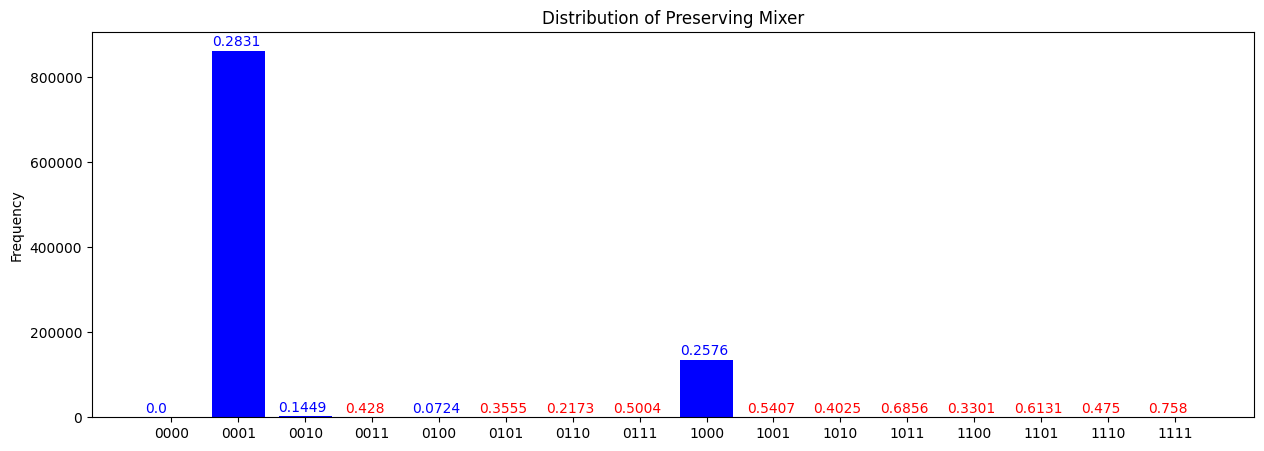

In [ ]:
# plt.figure(figsize=(100, 15))
plt.figure(figsize=(15, 5))
x = np.arange(2**n_qubit)

# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**n_qubit), result_final, color=colorr)
# plt.bar(range(int(2**(n_qubit-3)*0.1)), result_final[2**(n_qubit-3)*4:int(2**(n_qubit-3)*4.1)])
plt.ylabel('Frequency')
plt.title('Distribution of Preserving Mixer')
# plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
# plt.xticks(xlocs, xlabs)
plt.xticks(x, [f"{i:0{n_qubit}b}" for i in x])
xlocs, xlabs = plt.xticks()
# print(xlocs, xlabs)
for i, s in enumerate(ex_ret):
    plt.text(xlocs[i]-0.4, result_final[i]+result_final[int(state_high, 2)]/80, s, color=colorr[i])

plt.show()

Exhaustive Search

x: qubit (100 samples per qubit)
y: approx ratio (best vs real best)

Expectations file not found for Nelder-Mead
Expectations file not found for COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Expectations file not found for GradientDescent


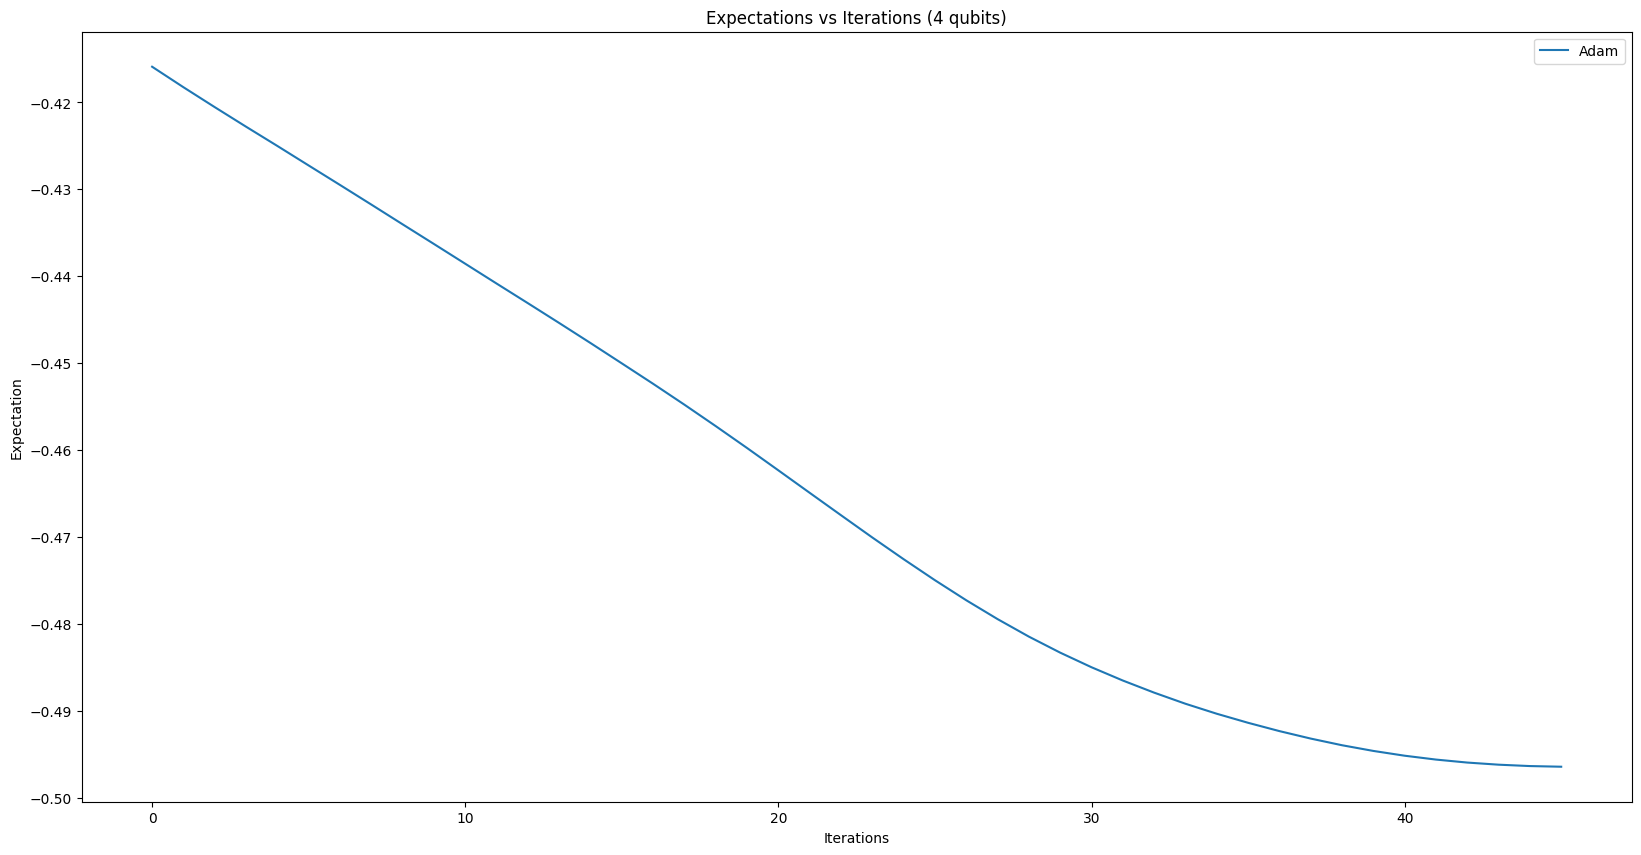

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()

Expectations file not found for Nelder-Mead
Expectations file not found for COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Expectations file not found for GradientDescent


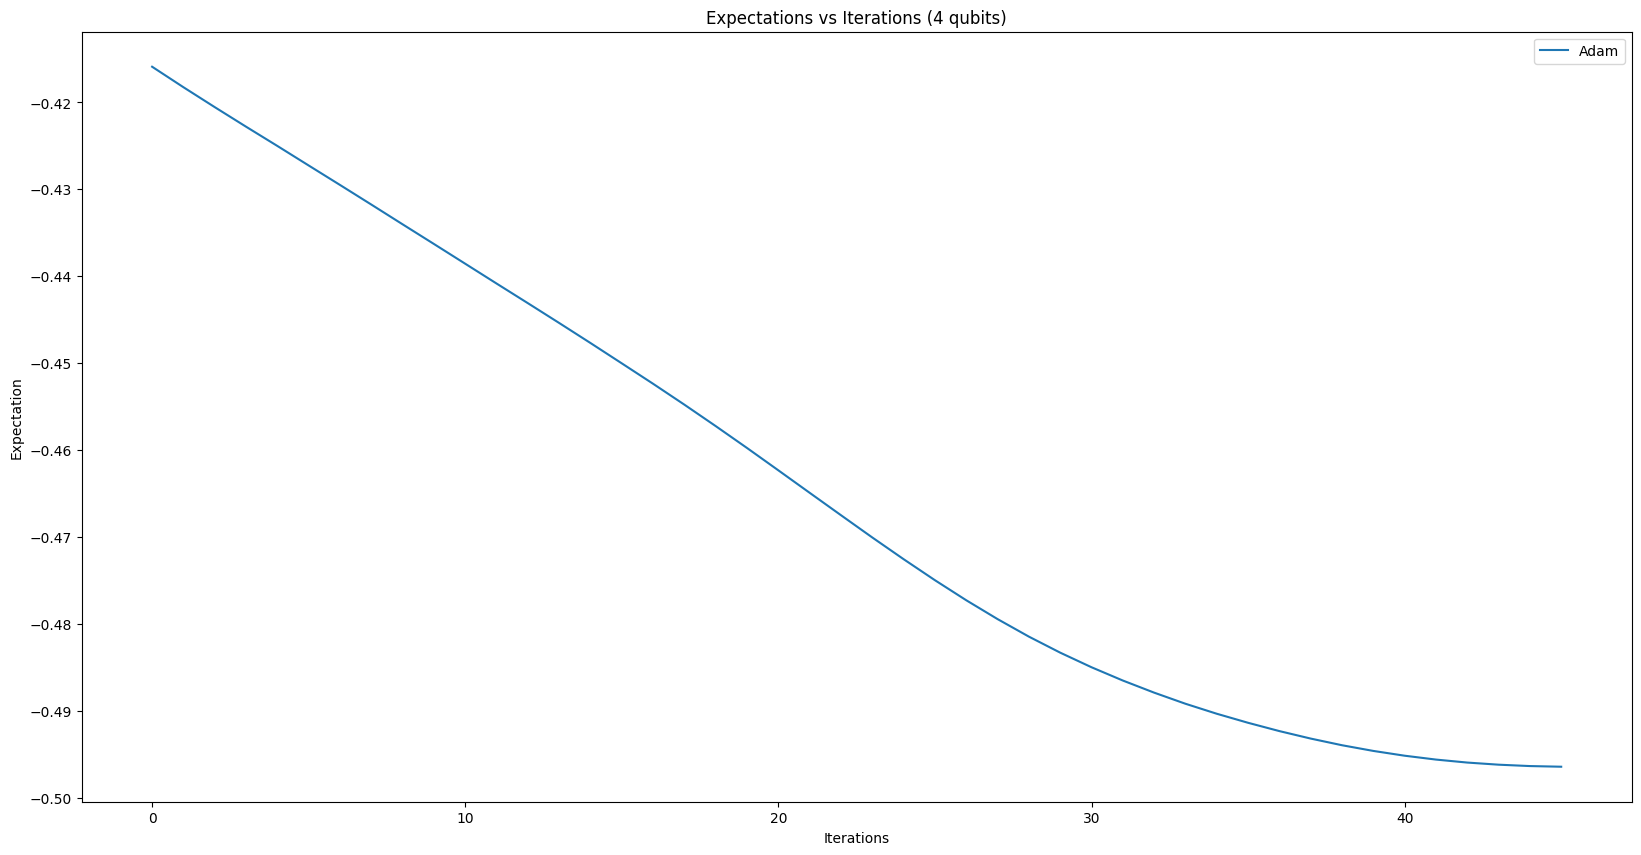

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()